In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.model_build import *
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 64
EPOCHS = 100
T = 500
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,image_fn
0,Bulbasaur,1,Grass,['1']
1,Ivysaur,2,Grass,['2']
2,Venusaur,3,Grass,['3']
3,Venusaur Gmax,3,Grass,['3_g']
4,Venusaur Mega,3,Grass,['3_2']
...,...,...,...,...
1113,Glastrier,896,Ice,['896']
1114,Spectrier,897,Ghost,['897']
1115,Calyrex,898,Psychic,['898_1']
1116,Calyrex Ice Rider,898,Psychic,['898_2']


- The shape of the dataset is: (64, 32, 32, 3) => batch_size: 64, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


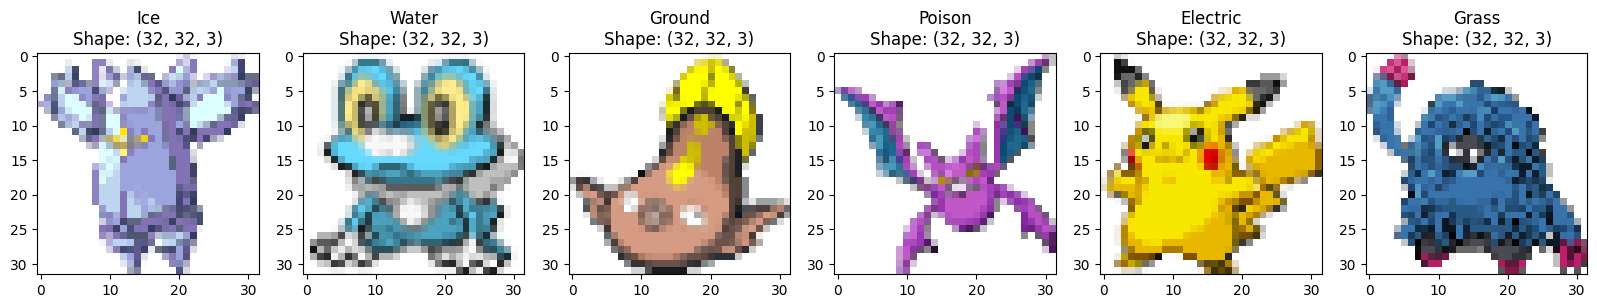

In [5]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES, num_channels=128, embedding_dim=128)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/100


I0000 00:00:1715201721.545432  117752 service.cc:145] XLA service 0x751dac002010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715201721.545464  117752 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1715201722.143223  117752 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1715201724.294616  117874 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6896', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1715201725.741974  117868 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6896', 440 bytes spill stores, 440 bytes spill loads

I0000 00:00:1715201746.719565  117752 asm_compiler.cc:369] ptxas

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 201ms/step - loss: 0.9093
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.3434
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.2431
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.2057
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2178
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1839
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2263
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1879
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2004
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2250
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2513
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.2141
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.1235
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.2409
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1

Sampling sprite: 500it [00:31, 15.87it/s]                         


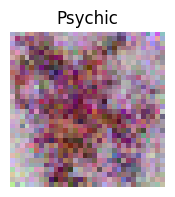

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 720ms/step - loss: 0.1940
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1412
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1571
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1509
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1969
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1127
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1032
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1896
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1165
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.1681
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1232
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1816
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - loss: 0.1650
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.1647
Epoch 34/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:29, 16.82it/s]                         


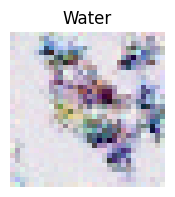

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 693ms/step - loss: 0.1279
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1684
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1483
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1599
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1808
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1441
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.1447
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.1678
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1824
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1446
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.1317
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.0948
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - loss: 0.1110
Epoch 53/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.1574
Epoch 54/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:30, 16.29it/s]                         


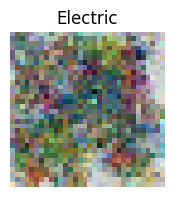

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 708ms/step - loss: 0.1232
Epoch 61/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1143
Epoch 62/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1422
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1681
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1365
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1216
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1340
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1248
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1033
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.1094
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.1299
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.1823
Epoch 72/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.1360
Epoch 73/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.1121
Epoch 74/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:29, 16.67it/s]                         


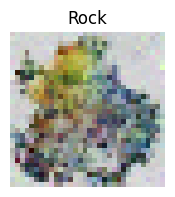

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 693ms/step - loss: 0.0909
Epoch 81/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0911
Epoch 82/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.1456
Epoch 83/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1231
Epoch 84/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1281
Epoch 85/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1300
Epoch 86/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1397
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.1254
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0983
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1189
Epoch 90/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0935
Epoch 91/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0949
Epoch 92/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - loss: 0.1329
Epoch 93/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - loss: 0.0884
Epoch 94/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:27, 18.13it/s]                         


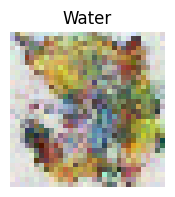

63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 648ms/step - loss: 0.1440


In [7]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1260
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1158
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1195
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1570
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1354
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1316
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0916
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.0970
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1521
Epoch 10/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1333
Epoch 11/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1034
Epoch 12/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.0910
Epoch 13/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.0995
Epoch 14/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1224
Epoch 15/500
63/63 ━━━━━━━━━━

Sampling sprite: 500it [00:28, 17.73it/s]                         


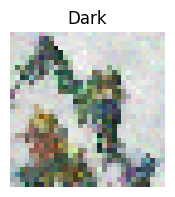

63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 660ms/step - loss: 0.1694
Epoch 21/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.1240
Epoch 22/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1316
Epoch 23/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1120
Epoch 24/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0853
Epoch 25/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1511
Epoch 26/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - loss: 0.1435
Epoch 27/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - loss: 0.1193
Epoch 28/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - loss: 0.0876
Epoch 29/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1104
Epoch 30/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.0752
Epoch 31/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.0948
Epoch 32/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1396
Epoch 33/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1192
Epoch 34/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:27, 18.14it/s]                         


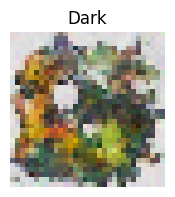

63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 647ms/step - loss: 0.1380
Epoch 41/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0985
Epoch 42/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0852
Epoch 43/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0795
Epoch 44/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1360
Epoch 45/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0898
Epoch 46/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1135
Epoch 47/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1038
Epoch 48/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1132
Epoch 49/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1237
Epoch 50/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1006
Epoch 51/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0984
Epoch 52/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1022
Epoch 53/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0927
Epoch 54/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:27, 18.15it/s]                         


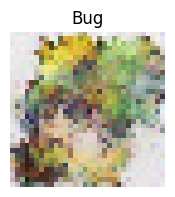

63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 647ms/step - loss: 0.0983
Epoch 61/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0974
Epoch 62/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.1330
Epoch 63/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1221
Epoch 64/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0915
Epoch 65/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1303
Epoch 66/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0905
Epoch 67/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1369
Epoch 68/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1027
Epoch 69/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.0820
Epoch 70/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1119
Epoch 71/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1382
Epoch 72/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1348
Epoch 73/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1386
Epoch 74/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:27, 18.16it/s]                         


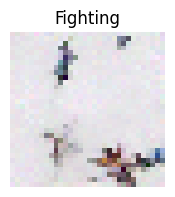

63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 647ms/step - loss: 0.1311
Epoch 81/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.1546
Epoch 82/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.1329
Epoch 83/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1105
Epoch 84/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1453
Epoch 85/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0882
Epoch 86/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.1057
Epoch 87/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1206
Epoch 88/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0990
Epoch 89/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0926
Epoch 90/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - loss: 0.1465
Epoch 91/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1169
Epoch 92/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.1109
Epoch 93/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1234
Epoch 94/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:28, 17.47it/s]                         


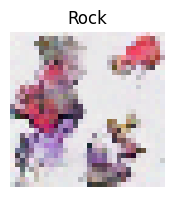

63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 668ms/step - loss: 0.1112
Epoch 101/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - loss: 0.0983
Epoch 102/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0901
Epoch 103/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0791
Epoch 104/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.1121
Epoch 105/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0916
Epoch 106/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0968
Epoch 107/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.1029
Epoch 108/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0844
Epoch 109/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 294ms/step - loss: 0.1192
Epoch 110/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 995ms/step - loss: 0.0781
Epoch 111/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - loss: 0.1056
Epoch 112/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - loss: 0.0840
Epoch 113/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.1649
Epoch 114/500
63/63 

Sampling sprite: 500it [00:27, 17.91it/s]                         


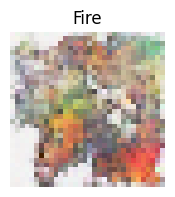

63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 651ms/step - loss: 0.0976
Epoch 121/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - loss: 0.1245
Epoch 122/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.1182
Epoch 123/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.1007
Epoch 124/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1043
Epoch 125/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.1294
Epoch 126/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0979
Epoch 127/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.1013
Epoch 128/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.0840
Epoch 129/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.1218
Epoch 130/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.1029
Epoch 131/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0936
Epoch 132/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0781
Epoch 133/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.1072
Epoch 134/500
63/63 

Sampling sprite: 500it [00:30, 16.42it/s]                         


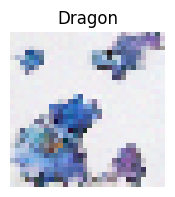

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 714ms/step - loss: 0.1148
Epoch 141/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0992
Epoch 142/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1046
Epoch 143/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.1214
Epoch 144/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0818
Epoch 145/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - loss: 0.1038
Epoch 146/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - loss: 0.1005
Epoch 147/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - loss: 0.0958
Epoch 148/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - loss: 0.1263
Epoch 149/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - loss: 0.0724
Epoch 150/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.1265
Epoch 151/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - loss: 0.1150
Epoch 152/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - loss: 0.1027
Epoch 153/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0980
Epoch 154/500
63/63 

Sampling sprite: 500it [00:30, 16.29it/s]                         


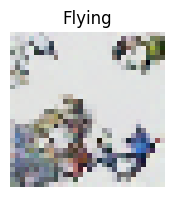

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 726ms/step - loss: 0.0950
Epoch 161/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.0839
Epoch 162/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.1228
Epoch 163/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - loss: 0.1086
Epoch 164/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.0975
Epoch 165/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.1289
Epoch 166/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.1057
Epoch 167/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0838
Epoch 168/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.1261
Epoch 169/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.1177
Epoch 170/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0898
Epoch 171/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0926
Epoch 172/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0802
Epoch 173/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.1267
Epoch 174/500
63/63 

Sampling sprite: 500it [00:30, 16.16it/s]                         


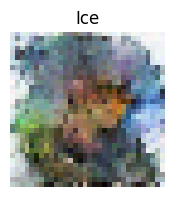

63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 729ms/step - loss: 0.1060
Epoch 181/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - loss: 0.0856
Epoch 182/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.1154
Epoch 183/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.0880
Epoch 184/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0662
Epoch 185/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.1055
Epoch 186/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.1056
Epoch 187/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0792
Epoch 188/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.0879
Epoch 189/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.1183
Epoch 190/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - loss: 0.1055
Epoch 191/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - loss: 0.0921
Epoch 192/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0838
Epoch 193/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.1027
Epoch 194/500
63/63 

Sampling sprite: 500it [00:30, 16.21it/s]                         


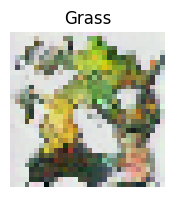

63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 732ms/step - loss: 0.1160
Epoch 201/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.1071
Epoch 202/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0786
Epoch 203/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.1033
Epoch 204/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0906
Epoch 205/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0920
Epoch 206/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.1204
Epoch 207/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.1001
Epoch 208/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - loss: 0.0872
Epoch 209/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - loss: 0.1095
Epoch 210/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.1031
Epoch 211/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - loss: 0.1311
Epoch 212/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0928
Epoch 213/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - loss: 0.0991
Epoch 214/500
63/63 

Sampling sprite: 500it [00:31, 16.11it/s]                         


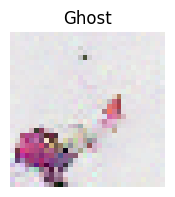

63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 739ms/step - loss: 0.1184
Epoch 221/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0811
Epoch 222/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0811
Epoch 223/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.1064
Epoch 224/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.0838
Epoch 225/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0879
Epoch 226/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - loss: 0.0754
Epoch 227/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0746
Epoch 228/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0906
Epoch 229/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - loss: 0.0866
Epoch 230/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - loss: 0.1134
Epoch 231/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - loss: 0.0828
Epoch 232/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - loss: 0.0820
Epoch 233/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - loss: 0.0815
Epoch 234/500
63/63 

Sampling sprite: 500it [00:30, 16.21it/s]                         


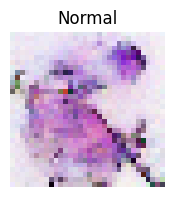

63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 729ms/step - loss: 0.1256
Epoch 241/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0983
Epoch 242/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.1007
Epoch 243/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - loss: 0.1065
Epoch 244/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.1044
Epoch 245/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - loss: 0.1130
Epoch 246/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.0981
Epoch 247/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0752
Epoch 248/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0910
Epoch 249/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - loss: 0.0962
Epoch 250/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - loss: 0.0758
Epoch 251/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0752
Epoch 252/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - loss: 0.0756
Epoch 253/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - loss: 0.0760
Epoch 254/500
63/63 

Sampling sprite: 500it [00:30, 16.21it/s]                         


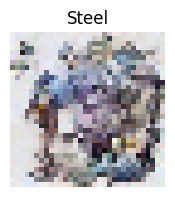

63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 730ms/step - loss: 0.1310
Epoch 261/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1058
Epoch 262/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0800
Epoch 263/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0922
Epoch 264/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.1197
Epoch 265/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.1184
Epoch 266/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - loss: 0.0933
Epoch 267/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0630
Epoch 268/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0963
Epoch 269/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0778
Epoch 270/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0774
Epoch 271/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - loss: 0.1357
Epoch 272/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.1140
Epoch 273/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - loss: 0.0895
Epoch 274/500
63/63 

Sampling sprite: 500it [00:30, 16.27it/s]                         


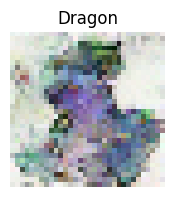

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 729ms/step - loss: 0.1155
Epoch 281/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.0927
Epoch 282/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0975
Epoch 283/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0955
Epoch 284/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.1217
Epoch 285/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0965
Epoch 286/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.1146
Epoch 287/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0884
Epoch 288/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0974
Epoch 289/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - loss: 0.0857
Epoch 290/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0967
Epoch 291/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - loss: 0.0920
Epoch 292/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - loss: 0.1195
Epoch 293/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.1546
Epoch 294/500
63/63 

Sampling sprite: 500it [00:31, 15.99it/s]                         


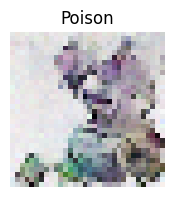

63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 742ms/step - loss: 0.0925
Epoch 301/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0637
Epoch 302/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0787
Epoch 303/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.1311
Epoch 304/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.0859
Epoch 305/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.1042
Epoch 306/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0889
Epoch 307/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.0848
Epoch 308/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0859
Epoch 309/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0892
Epoch 310/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - loss: 0.1101
Epoch 311/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0851
Epoch 312/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0860
Epoch 313/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.1026
Epoch 314/500
63/63 

Sampling sprite: 500it [00:30, 16.18it/s]                         


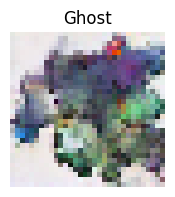

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 729ms/step - loss: 0.0905
Epoch 321/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.1008
Epoch 322/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0920
Epoch 323/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - loss: 0.0621
Epoch 324/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0877
Epoch 325/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - loss: 0.0950
Epoch 326/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0968
Epoch 327/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.1213
Epoch 328/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.1008
Epoch 329/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.1090
Epoch 330/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0815
Epoch 331/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0769
Epoch 332/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0892
Epoch 333/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0879
Epoch 334/500
63/63 

Sampling sprite: 500it [00:30, 16.25it/s]                         


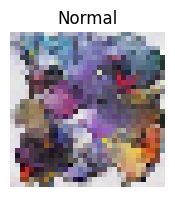

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 729ms/step - loss: 0.0839
Epoch 341/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - loss: 0.0992
Epoch 342/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0785
Epoch 343/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.0736
Epoch 344/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0707
Epoch 345/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0883
Epoch 346/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - loss: 0.1070
Epoch 347/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0865
Epoch 348/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0870
Epoch 349/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0687
Epoch 350/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0885
Epoch 351/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0818
Epoch 352/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.1025
Epoch 353/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0802
Epoch 354/500
63/63 

Sampling sprite: 500it [00:30, 16.28it/s]                         


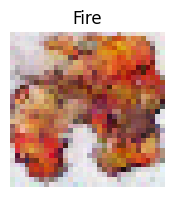

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 729ms/step - loss: 0.1100
Epoch 361/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.0714
Epoch 362/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0877
Epoch 363/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - loss: 0.0890
Epoch 364/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0970
Epoch 365/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0863
Epoch 366/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0707
Epoch 367/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.1255
Epoch 368/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0808
Epoch 369/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.0839
Epoch 370/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0967
Epoch 371/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0757
Epoch 372/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.1144
Epoch 373/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.1319
Epoch 374/500
63/63 

Sampling sprite: 500it [00:30, 16.24it/s]                         


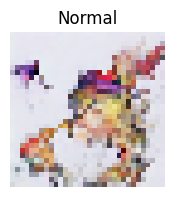

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 728ms/step - loss: 0.0987
Epoch 381/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - loss: 0.0970
Epoch 382/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0854
Epoch 383/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - loss: 0.0704
Epoch 384/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.0881
Epoch 385/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0844
Epoch 386/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0801
Epoch 387/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0767
Epoch 388/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0935
Epoch 389/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0927
Epoch 390/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0939
Epoch 391/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.1000
Epoch 392/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.0897
Epoch 393/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0897
Epoch 394/500
63/63 

Sampling sprite: 500it [00:30, 16.15it/s]                         


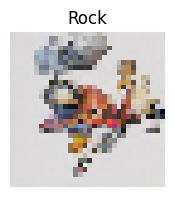

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 729ms/step - loss: 0.0923
Epoch 401/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.0886
Epoch 402/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.1106
Epoch 403/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - loss: 0.0834
Epoch 404/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.0775
Epoch 405/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.0739
Epoch 406/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.1083
Epoch 407/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0995
Epoch 408/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.1078
Epoch 409/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.0868
Epoch 410/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.0998
Epoch 411/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.0900
Epoch 412/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0783
Epoch 413/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.0934
Epoch 414/500
63/63 

Sampling sprite: 500it [00:30, 16.30it/s]                         


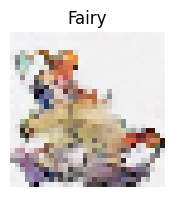

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 725ms/step - loss: 0.0806
Epoch 421/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.0951
Epoch 422/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.1195
Epoch 423/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.0997
Epoch 424/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.0927
Epoch 425/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.0868
Epoch 426/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.1117
Epoch 427/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.1049
Epoch 428/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0836
Epoch 429/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0820
Epoch 430/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.1239
Epoch 431/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0918
Epoch 432/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0832
Epoch 433/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0729
Epoch 434/500
63/63 

Sampling sprite: 500it [00:30, 16.21it/s]                         


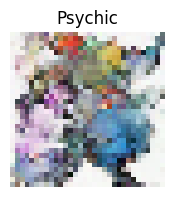

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 727ms/step - loss: 0.0764
Epoch 441/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.0726
Epoch 442/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.1012
Epoch 443/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.1120
Epoch 444/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - loss: 0.0680
Epoch 445/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.0902
Epoch 446/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.0932
Epoch 447/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.1000
Epoch 448/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.1116
Epoch 449/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0999
Epoch 450/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.1154
Epoch 451/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.0733
Epoch 452/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0881
Epoch 453/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0866
Epoch 454/500
63/63 

Sampling sprite: 500it [00:30, 16.16it/s]                         


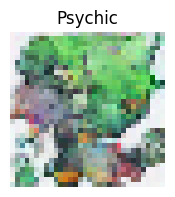

63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 731ms/step - loss: 0.1068
Epoch 461/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - loss: 0.0931
Epoch 462/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0636
Epoch 463/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.1249
Epoch 464/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.1124
Epoch 465/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.0941
Epoch 466/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.0965
Epoch 467/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.1045
Epoch 468/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0749
Epoch 469/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.1131
Epoch 470/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0739
Epoch 471/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.0830
Epoch 472/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0757
Epoch 473/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.1071
Epoch 474/500
63/63 

Sampling sprite: 500it [00:31, 15.95it/s]                         


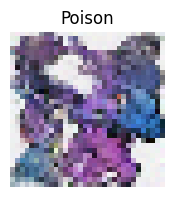

63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 739ms/step - loss: 0.0927
Epoch 481/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0871
Epoch 482/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.0765
Epoch 483/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - loss: 0.0938
Epoch 484/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - loss: 0.0724
Epoch 485/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0832
Epoch 486/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.0843
Epoch 487/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - loss: 0.0735
Epoch 488/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.1242
Epoch 489/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.1101
Epoch 490/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0687
Epoch 491/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.0981
Epoch 492/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0881
Epoch 493/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.1174
Epoch 494/500
63/63 

Sampling sprite: 500it [00:30, 16.17it/s]                         


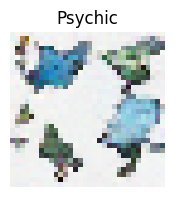

63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 730ms/step - loss: 0.0853


In [8]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0909
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0908
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0982
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0806
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0926
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0940
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0976
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0772
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0776
Epoch 10/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0742
Epoch 11/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0953
Epoch 12/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0995
Epoch 13/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0867
Epoch 14/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0613
Epoch 15/500
63/63 ━━━━━━━━━━

Sampling sprite: 500it [00:29, 17.13it/s]                         


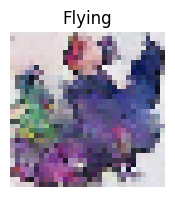

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 695ms/step - loss: 0.0975
Epoch 21/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0836
Epoch 22/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0839
Epoch 23/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.0756
Epoch 24/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.1038
Epoch 25/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0925
Epoch 26/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0805
Epoch 27/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0706
Epoch 28/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0888
Epoch 29/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0704
Epoch 30/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.1002
Epoch 31/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0830
Epoch 32/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0838
Epoch 33/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0899
Epoch 34/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:29, 17.09it/s]                         


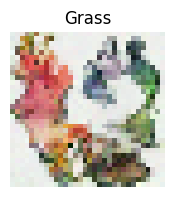

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 692ms/step - loss: 0.1012
Epoch 41/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0838
Epoch 42/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0765
Epoch 43/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.0843
Epoch 44/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.1041
Epoch 45/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.1078
Epoch 46/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0680
Epoch 47/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.1104
Epoch 48/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.1007
Epoch 49/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0564
Epoch 50/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0814
Epoch 51/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0925
Epoch 52/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.1155
Epoch 53/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.1211
Epoch 54/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:29, 17.04it/s]                         


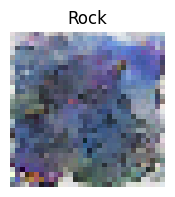

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 696ms/step - loss: 0.0843
Epoch 61/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0858
Epoch 62/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1015
Epoch 63/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - loss: 0.0955
Epoch 64/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0820
Epoch 65/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0807
Epoch 66/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.1003
Epoch 67/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0906
Epoch 68/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0791
Epoch 69/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.1084
Epoch 70/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.1030
Epoch 71/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0875
Epoch 72/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0969
Epoch 73/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0634
Epoch 74/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:29, 17.03it/s]                         


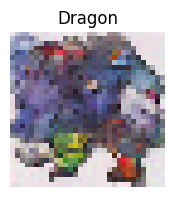

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 697ms/step - loss: 0.0863
Epoch 81/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0879
Epoch 82/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0704
Epoch 83/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.0826
Epoch 84/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.1065
Epoch 85/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.1166
Epoch 86/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0744
Epoch 87/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0849
Epoch 88/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0989
Epoch 89/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0912
Epoch 90/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0787
Epoch 91/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0916
Epoch 92/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0971
Epoch 93/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0849
Epoch 94/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:29, 17.09it/s]                         


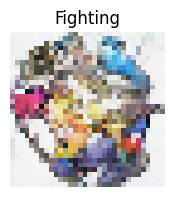

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 693ms/step - loss: 0.1026
Epoch 101/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0932
Epoch 102/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - loss: 0.0776
Epoch 103/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.0862
Epoch 104/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0889
Epoch 105/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0757
Epoch 106/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0871
Epoch 107/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0605
Epoch 108/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.1041
Epoch 109/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0758
Epoch 110/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0933
Epoch 111/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0799
Epoch 112/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.1089
Epoch 113/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.1023
Epoch 114/500
63/63 

Sampling sprite: 500it [00:29, 16.99it/s]                         


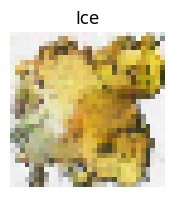

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 698ms/step - loss: 0.0948
Epoch 121/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0834
Epoch 122/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0831
Epoch 123/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.0747
Epoch 124/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.1073
Epoch 125/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0596
Epoch 126/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0770
Epoch 127/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0712
Epoch 128/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.1089
Epoch 129/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0986
Epoch 130/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0647
Epoch 131/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.1020
Epoch 132/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0687
Epoch 133/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0961
Epoch 134/500
63/63 

Sampling sprite: 500it [00:29, 16.98it/s]                         


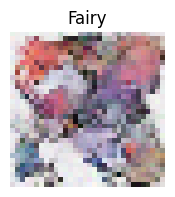

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 694ms/step - loss: 0.0713
Epoch 141/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0962
Epoch 142/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1174
Epoch 143/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.0734
Epoch 144/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.1040
Epoch 145/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0919
Epoch 146/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.0666
Epoch 147/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0718
Epoch 148/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.1134
Epoch 149/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0801
Epoch 150/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0698
Epoch 151/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.1010
Epoch 152/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.1013
Epoch 153/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0996
Epoch 154/500
63/63 

Sampling sprite: 500it [00:29, 16.90it/s]                         


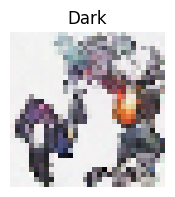

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 697ms/step - loss: 0.0678
Epoch 161/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.1230
Epoch 162/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.1011
Epoch 163/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.1136
Epoch 164/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0918
Epoch 165/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0854
Epoch 166/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0863
Epoch 167/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0888
Epoch 168/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0677
Epoch 169/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0755
Epoch 170/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0865
Epoch 171/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0941
Epoch 172/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.1107
Epoch 173/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0850
Epoch 174/500
63/63 

Sampling sprite: 500it [00:29, 17.00it/s]                         


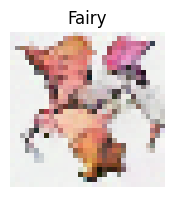

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 697ms/step - loss: 0.0796
Epoch 181/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0765
Epoch 182/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.1096
Epoch 183/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.0781
Epoch 184/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0705
Epoch 185/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0689
Epoch 186/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0885
Epoch 187/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0874
Epoch 188/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0600
Epoch 189/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0908
Epoch 190/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0779
Epoch 191/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0748
Epoch 192/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0773
Epoch 193/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0797
Epoch 194/500
63/63 

Sampling sprite: 500it [00:29, 17.07it/s]                         


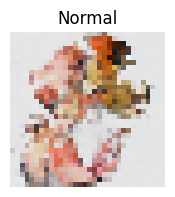

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 693ms/step - loss: 0.0694
Epoch 201/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.1047
Epoch 202/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.1251
Epoch 203/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.1037
Epoch 204/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0675
Epoch 205/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.1071
Epoch 206/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0747
Epoch 207/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0878
Epoch 208/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0870
Epoch 209/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0639
Epoch 210/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0956
Epoch 211/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0943
Epoch 212/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0928
Epoch 213/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.1078
Epoch 214/500
63/63 

Sampling sprite: 500it [00:29, 17.10it/s]                         


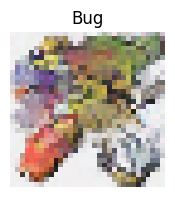

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 694ms/step - loss: 0.0640
Epoch 221/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0783
Epoch 222/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0803
Epoch 223/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.0746
Epoch 224/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.1101
Epoch 225/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0992
Epoch 226/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.1211
Epoch 227/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0737
Epoch 228/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0777
Epoch 229/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0713
Epoch 230/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0929
Epoch 231/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0671
Epoch 232/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0856
Epoch 233/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0863
Epoch 234/500
63/63 

Sampling sprite: 500it [00:29, 16.95it/s]                         


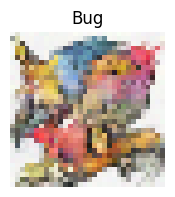

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 696ms/step - loss: 0.0993
Epoch 241/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0990
Epoch 242/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0895
Epoch 243/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.0922
Epoch 244/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0668
Epoch 245/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0906
Epoch 246/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.1014
Epoch 247/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0733
Epoch 248/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0786
Epoch 249/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0679
Epoch 250/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0743
Epoch 251/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0749
Epoch 252/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0808
Epoch 253/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0948
Epoch 254/500
63/63 

Sampling sprite: 500it [00:29, 17.12it/s]                         


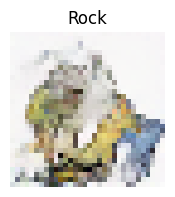

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 693ms/step - loss: 0.0816
Epoch 261/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0889
Epoch 262/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - loss: 0.0804
Epoch 263/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.0657
Epoch 264/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0865
Epoch 265/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.1044
Epoch 266/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.1055
Epoch 267/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0915
Epoch 268/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0898
Epoch 269/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0954
Epoch 270/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.1014
Epoch 271/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0753
Epoch 272/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0842
Epoch 273/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.1049
Epoch 274/500
63/63 

Sampling sprite: 500it [00:29, 17.17it/s]                         


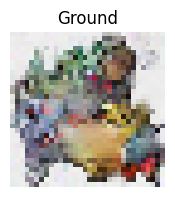

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 693ms/step - loss: 0.0729
Epoch 281/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0870
Epoch 282/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0755
Epoch 283/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - loss: 0.0838
Epoch 284/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.1173
Epoch 285/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.1077
Epoch 286/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0859
Epoch 287/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.1083
Epoch 288/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0673
Epoch 289/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0860
Epoch 290/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0765
Epoch 291/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0748
Epoch 292/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0789
Epoch 293/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.1232
Epoch 294/500
63/63 

Sampling sprite: 500it [00:29, 17.01it/s]                         


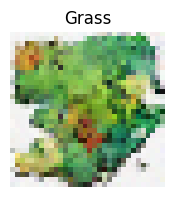

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 697ms/step - loss: 0.0770
Epoch 301/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0917
Epoch 302/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.1063
Epoch 303/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.0961
Epoch 304/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0849
Epoch 305/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0771
Epoch 306/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.0841
Epoch 307/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0957
Epoch 308/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0939
Epoch 309/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0844
Epoch 310/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0945
Epoch 311/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0647
Epoch 312/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0986
Epoch 313/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0794
Epoch 314/500
63/63 

Sampling sprite: 500it [00:29, 16.97it/s]                         


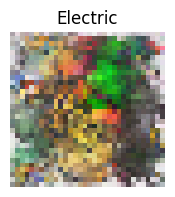

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 695ms/step - loss: 0.1247
Epoch 321/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.1310
Epoch 322/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0887
Epoch 323/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.0889
Epoch 324/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.0930
Epoch 325/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0810
Epoch 326/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.1103
Epoch 327/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0732
Epoch 328/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0865
Epoch 329/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0716
Epoch 330/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0978
Epoch 331/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.1161
Epoch 332/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0980
Epoch 333/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0942
Epoch 334/500
63/63 

Sampling sprite: 500it [00:29, 16.83it/s]                         


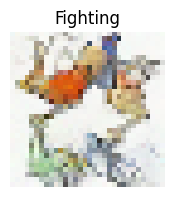

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 700ms/step - loss: 0.0850
Epoch 341/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0725
Epoch 342/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0634
Epoch 343/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.0944
Epoch 344/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0860
Epoch 345/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0811
Epoch 346/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0741
Epoch 347/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0965
Epoch 348/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0748
Epoch 349/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0828
Epoch 350/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0507
Epoch 351/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0800
Epoch 352/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0776
Epoch 353/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - loss: 0.0654
Epoch 354/500
63/63 

Sampling sprite: 500it [00:29, 17.01it/s]                         


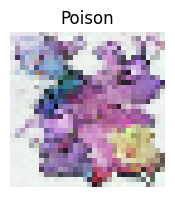

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 696ms/step - loss: 0.0776
Epoch 361/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.1058
Epoch 362/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.1113
Epoch 363/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.0702
Epoch 364/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0763
Epoch 365/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0880
Epoch 366/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0660
Epoch 367/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0673
Epoch 368/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0967
Epoch 369/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0872
Epoch 370/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0667
Epoch 371/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0970
Epoch 372/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.1097
Epoch 373/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0910
Epoch 374/500
63/63 

Sampling sprite: 500it [00:29, 16.92it/s]                         


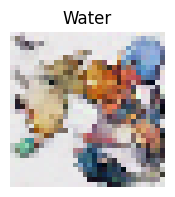

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 700ms/step - loss: 0.0856
Epoch 381/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0777
Epoch 382/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0632
Epoch 383/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 0.0834
Epoch 384/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0850
Epoch 385/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0915
Epoch 386/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.1001
Epoch 387/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0700
Epoch 388/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - loss: 0.0791
Epoch 389/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0851
Epoch 390/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0795
Epoch 391/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0807
Epoch 392/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0816
Epoch 393/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0845
Epoch 394/500
63/63 

Sampling sprite: 500it [00:29, 17.13it/s]                         


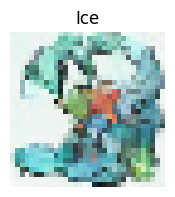

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 691ms/step - loss: 0.0808
Epoch 401/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0707
Epoch 402/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0738
Epoch 403/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0721
Epoch 404/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.1349
Epoch 405/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0903
Epoch 406/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0732
Epoch 407/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.1039
Epoch 408/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.1160
Epoch 409/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0663
Epoch 410/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0728
Epoch 411/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0789
Epoch 412/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - loss: 0.0938
Epoch 413/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0788
Epoch 414/500
63/63 

Sampling sprite: 500it [00:29, 16.88it/s]                         


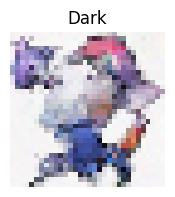

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 699ms/step - loss: 0.0759
Epoch 421/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0774
Epoch 422/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0620
Epoch 423/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.0742
Epoch 424/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0690
Epoch 425/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0782
Epoch 426/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0548
Epoch 427/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0863
Epoch 428/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0591
Epoch 429/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0743
Epoch 430/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.1082
Epoch 431/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0960
Epoch 432/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0949
Epoch 433/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0923
Epoch 434/500
63/63 

Sampling sprite: 500it [00:29, 16.98it/s]                         


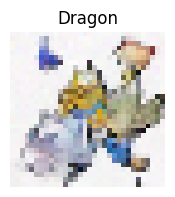

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 696ms/step - loss: 0.0868
Epoch 441/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0754
Epoch 442/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - loss: 0.0826
Epoch 443/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.0725
Epoch 444/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.1043
Epoch 445/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.1003
Epoch 446/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0709
Epoch 447/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0661
Epoch 448/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0689
Epoch 449/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0796
Epoch 450/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0851
Epoch 451/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.1006
Epoch 452/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0840
Epoch 453/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0860
Epoch 454/500
63/63 

Sampling sprite: 500it [00:29, 16.91it/s]                         


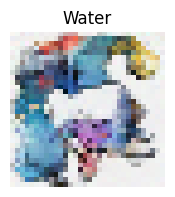

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 698ms/step - loss: 0.0947
Epoch 461/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0836
Epoch 462/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.0900
Epoch 463/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - loss: 0.0836
Epoch 464/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.1094
Epoch 465/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.0900
Epoch 466/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0750
Epoch 467/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0558
Epoch 468/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - loss: 0.0801
Epoch 469/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0977
Epoch 470/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0977
Epoch 471/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0847
Epoch 472/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0966
Epoch 473/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 0.0866
Epoch 474/500
63/63 

Sampling sprite: 500it [00:29, 16.91it/s]                         


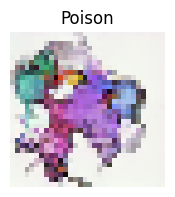

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 698ms/step - loss: 0.0784
Epoch 481/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.0794
Epoch 482/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.0796
Epoch 483/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.0868
Epoch 484/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 0.0699
Epoch 485/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.1074
Epoch 486/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.1088
Epoch 487/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0805
Epoch 488/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0963
Epoch 489/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0741
Epoch 490/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0671
Epoch 491/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0905
Epoch 492/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.0917
Epoch 493/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - loss: 0.0818
Epoch 494/500
63/63 

Sampling sprite: 500it [00:29, 16.91it/s]                         


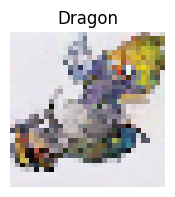

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 698ms/step - loss: 0.0814


In [9]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.20it/s]                         


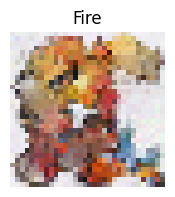

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.57it/s]                         


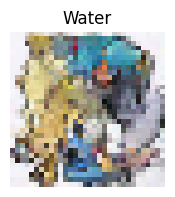

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.49it/s]                         


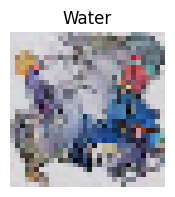

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.58it/s]                         


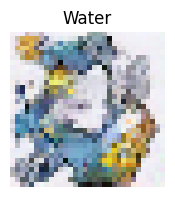

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.48it/s]                         


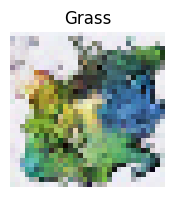

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.66it/s]                         


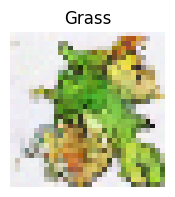

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.64it/s]                         


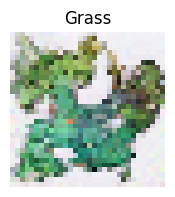

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.57it/s]                         


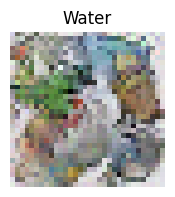

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.48it/s]                         


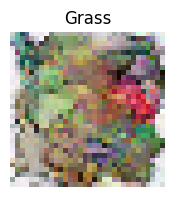

In [18]:
for i in range(9):
    p_type = ["Fire", "Water", "Grass"]
    p_type_random = np.random.choice(p_type)
    model.plot_samples(1, p_type_random)

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.83it/s]                         


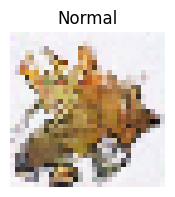

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.46it/s]                         


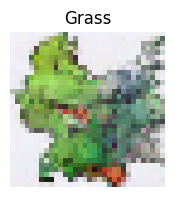

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.75it/s]                         


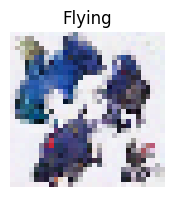

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.52it/s]                         


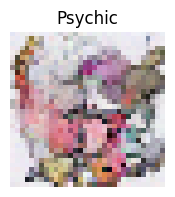

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.76it/s]                         


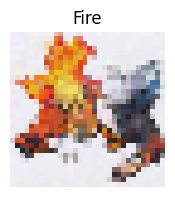

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.73it/s]                         


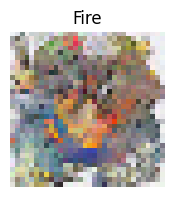

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.24it/s]                         


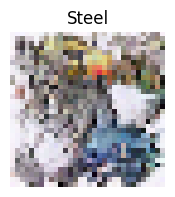

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.55it/s]                         


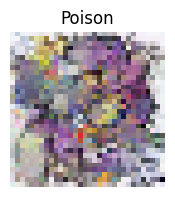

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.43it/s]                         


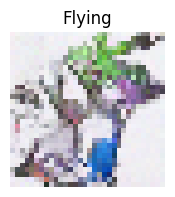

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.44it/s]                         


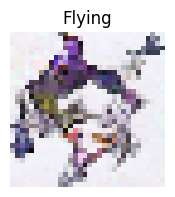

In [17]:
for i in range(10):
    model.plot_samples(1)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [12]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [13]:
# Save the model
SCHEDULER = "linear"
EPOCHS = 1100
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm_attention_time_sin"

save_model(model, model_name)

/home/pqlza/.local/lib/python3.11/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


Model diffusion_32_64_1100_500_linear_ddpm_attention_time_sin, saved successfully!


In [14]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

TypeError: <class 'src.model.overfitting_test.DiffusionModel'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'src.model.overfitting_test', 'class_name': 'DiffusionModel', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'DiffusionModel', 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 9.999999747378752e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'MeanSquaredError', 'config': {'name': 'mean_squared_error', 'reduction': 'sum_over_batch_size'}, 'registered_name': None}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class 'src.model.overfitting_test.DiffusionModel'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of DiffusionModel from its config.

Received config={'trainable': True, 'dtype': 'float32'}

Error encountered during deserialization: DiffusionModel.__init__() got an unexpected keyword argument 'trainable'

[BACK TO TOP](#top)